# Pryngles module: physics

Template of a module

In [1]:
from pryngles import *

## External modules

In [2]:
#@external
import numpy as np
import rebound as rb
from tqdm import tqdm
#@end:external

## Orbit of Hierarchical N-body system

### Docstring

In [57]:
Orbit_doc="""Hierarchical N-body system.

Initialization parameters+:

    m1,m2: mixed, default = 1:
        If m1 (m2) is a number, this is the mass of the first body.
        If m1 (m2) is an instance of Orbit, this is a children system.

    elements: dictionary:
        Dictionary with the elements provided to indicate the location of the relative 
        vector of the system.
        
        Valid orbital elements are:
            
            a=1,f=0,e=0: 
                Semi major axis, true anomaly, eccentricity.
            
            omega=0,inc=0,Omega=0:
                Periapsis argument, inclination, longitude of the ascending node.

            M=0,E=0,T=0:
                Mean anomaly, eccentric anomaly, time of periapsis passage.
                
            theta=0,l=0:
                True longitude (Omega + omega + f), mean longitude (Omega + omega + M).

    R: array (3), default = [0,0,0]
        Initial position of the center of mass.
    
    V: array (3), default = [0,0,0]
        Initial velocity of the center of mass.
    
Secondary attributes:

    m1, m2: float:
        Masses of the particles.

    Mtot: float:
        Total mass of the system.
    
    sub_sim: Rebound Simulation:
        Simulation corresponding to the motion of the two particles.
        
    sim: Rebound simulation:
        Simulation corresponding to all particles in the system.

Key methods:

    get_positions():
    
        Returns:
            states: list (N) of dictionaries:
                List of dictionaries having the state vector x,y,z,vx,vy,vz of 
                each particle.

All methods:
    See Misc.get_methods(Orbit)
    
Examples:

    Complex system: two binaries orbited by a further away object:
    
        S1=Orbit(m1=1,m2=1,a=1,e=0.7,M=0)
        S2=Orbit(m1=1,m2=1,a=1,e=0,M=0)
        S3=Orbit(S1,S2,a=5,e=0)
        S4=Orbit(S3,m2=1,a=20,e=0,E=45*Consts.deg)
        S4.ensamble_system()
        Plot.animate_rebound(S4.sim)
        
    Planet with a moon:
        units=["au","msun","yr"]
        orb=Orbit(
            m1=1,
            m2=Orbit(m1=1e-3,m2=1e-7,a=0.5,e=0.0,units=units),
            units=units,
            a=20,e=0.0)
        orb.calculate_orbit()
        sim,states=orb.get_states()
        Plot.animate_rebound(sim)
        
    Simple system:
        units=["au","msun","yr"]
        sim,states=Orbit(m1=1.0,m2=1e-3,units=units,a=0.1,e=0.0).calculate_orbit().get_states()
        
"""

### Class HNbody

In [58]:
class Orbit(PrynglesCommon):
    
    def __init__(self,m1=1,m2=1,
                 R=np.array([0,0,0]),V=np.array([0,0,0]),
                 units=None,
                 **elements):
        
        #Global simularion
        self.sim=rb.Simulation()
        if units:
            self.units=units
        else:
            self.units=["au","msun","yr2pi"]
        self.sim.units=self.units

        #Particles
        self.p1=m1
        self.p2=m2
        
        #Periods
        self.Ps=[]
        
        #Check first system
        qmixed=False
        if isinstance(self.p1,Orbit):
            self.m1=self.p1.Mtot
            qmixed=True
        elif isinstance(self.p1,float) or isinstance(self.p1,int):
            self.m1=self.p1
        else:
            raise ValueError(f"Type of first componente ({type(m1)}) not recognized.  It should be a float or an Orbit instance.")
        
        #Check second system
        if isinstance(self.p2,Orbit):
            self.m2=self.p2.Mtot
            qmixed=True
        elif isinstance(self.p2,float) or isinstance(self.p2,int):
            self.m2=self.p2
        else:
            raise ValueError(f"Type of Second component ({type(m2)}) not recognized.  It should be a float or an Orbit instance.")
                
        if not qmixed and (sum(R)!=0 or sum(V)!=0):
            raise ValueError(f"You cannot provide a center of mass position and velocity for a non-mixed system.")
        
        #Total mass
        self.Mtot=self.m1+self.m2
        
        #Add initial elements to attributes
        for element in elements:
            if element in REBOUND_ORBITAL_PROPERTIES:
                self.__dict__[element]=elements[element]
            else:
                raise ValueError(f"Element {element} not identified.")
                
        #Update states
        self._update_states(R,V)
        
    def _update_states(self,R=np.array([0,0,0]),V=np.array([0,0,0])):
        """Update state of the particles
        """        
        #Create rebound obtions
        self._rb_options={k:v for k,v in self.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}  
        self._rb_options.update(dict(m=0))
        
        #Create rebound simulation
        sim=rb.Simulation()
        sim.units=self.units
        sim.add(m=self.Mtot)
        sim.add(**self._rb_options)
        
        #Relative vector
        self.r=np.array(sim.particles[1].xyz)
        self.v=np.array(sim.particles[1].vxyz)
        
        del sim
        
        #Calculate positions of components
        self.r1=R-self.m2/self.Mtot*self.r
        self.v1=V-self.m2/self.Mtot*self.v
        
        if isinstance(self.p1,Orbit):
            self.p1._update_states(self.r1,self.v1)
            
        self.r2=R+self.m1/self.Mtot*self.r
        self.v2=V+self.m1/self.Mtot*self.v                
        if isinstance(self.p2,Orbit):
            self.p2._update_states(self.r2,self.v2)
            
        #Create a simulation of this system
        self.sub_sim=rb.Simulation()
        self.sub_sim.units=self.units
        self.sub_sim.add(m=self.m1,
                         x=self.r1[0],y=self.r1[1],z=self.r1[2],
                         vx=self.v1[0],vy=self.v1[1],vz=self.v1[2])
        self.sub_sim.add(m=self.m2,
                         x=self.r2[0],y=self.r2[1],z=self.r2[2],
                         vx=self.v2[0],vy=self.v2[1],vz=self.v2[2])

    def calculate_orbit(self,sim=None):
        """Ensamble Hierarchical N-body system.
        
        Parameters:
            sim: Rebound Simulation, default = None:
                This is used for recursion purposes.  
                Normally is set to None.
        
        Return:
            orbit: Orbit object:
                Used for nested purposes, 
                Example: orbit.calculate_orbit().get_states()
        """
        if sim is None:
            sim=self.sim
            
        if isinstance(self.p1,Orbit):
            self.p1.calculate_orbit(sim)
        else:
            sim.add(m=self.m1,
                    x=self.r1[0],y=self.r1[1],z=self.r1[2],
                    vx=self.v1[0],vy=self.v1[1],vz=self.v1[2])
            
        if isinstance(self.p2,Orbit):
            self.p2.calculate_orbit(sim)
        else:
            sim.add(m=self.m2,
                    x=self.r2[0],y=self.r2[1],z=self.r2[2],
                    vx=self.v2[0],vy=self.v2[1],vz=self.v2[2])
            
        for p in sim.particles[1:]:
            self.Ps+=[p.P]
        return self
            
    def get_states(self):
        """Get positions of particles in the system
        
        Returns:
            states: list (N) of dictionaries:
                List of dictionaries having the state vector x,y,z,vx,vy,vz of 
                each particle.        
        """
        states=[]
        for p in self.sim.particles:
            states+=[
                dict(m=p.m,x=p.x,y=p.y,z=p.z,vx=p.vx,vy=p.vy,vz=p.vz)
            ]
        return self.sim,states

In [56]:
#@test:template
if IN_JUPYTER:
    
    def test_Orbit(self):
        
        #Quintuple system
        S1=Orbit(m1=1,m2=1,a=1,e=0.7,M=0)
        S2=Orbit(m1=1,m2=1,a=1,e=0,M=0)
        S3=Orbit(S1,S2,a=5,e=0)
        S4=Orbit(S3,m2=1,a=20,e=0,E=45*Consts.deg)
        S4.calculate_orbit()
        print(S4.get_states())
        print(S4.Ps)
        
        #Using custom units
        #Quintuple system

        #Initialize positions
        hn=Orbit(
            m1=1,
            m2=Orbit(m1=1e-3,m2=1e-7,a=0.5,e=0.0,units=units),
            units=units,
            a=20,e=0.0)
        hn.calculate_orbit()
        sim,states=hn.get_states()
        print(states)
        
        #SImple 
        
        #Use this code to animate:
        #Plot.animate_rebound(S4.sim)
        
    class Test(unittest.TestCase):pass
    Test.test_Orbit=test_Orbit
    unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end

.

(<rebound.simulation.Simulation object at 0x7fbebcf85f40, N=5, t=0.0>, [{'m': 1.0, 'x': -5.47842712474619, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': -2.2011750966789583, 'vz': 0.0}, {'m': 1.0, 'x': -5.1784271247461895, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': 1.1653265494417333, 'vz': 0.0}, {'m': 1.0, 'x': -0.8284271247461903, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': -0.3306038638052443, 'vz': 0.0}, {'m': 1.0, 'x': 0.1715728752538097, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': 1.0836096985678507, 'vz': 0.0}, {'m': 1.0, 'x': 11.313708498984761, 'y': 11.31370849898476, 'z': 0.0, 'vx': -0.28284271247461895, 'vy': 0.282842712474619, 'vz': 0.0}])
[4.4428829381584665, 12.74284608459776, -112.2111774360127, 251.32741228718336]
[{'m': 1.0, 'x': -0.01998201598581259, 'y': 0.0, 'z': 0.0, 'vx': 0.0, 'vy': -0.0014043748232577592, 'vz': 0.0}, {'m': 0.001, 'x': 19.97996798901369, 'y': 0.0, 'z': 0.0, 


----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


--End--

## Scatterer Class

<IPython.core.display.Javascript object>


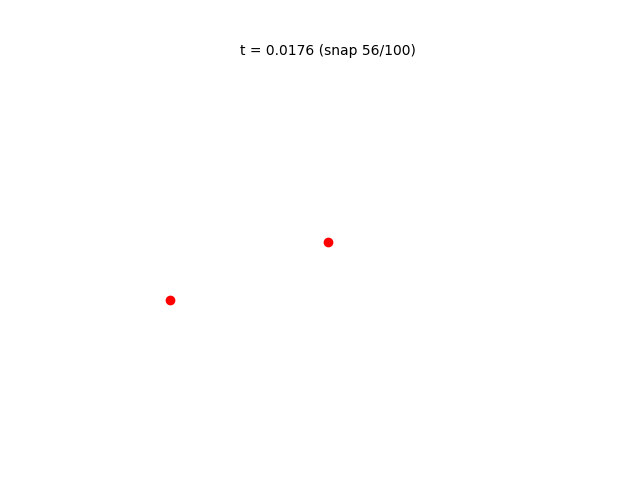

100%|██████████| 100/100 [00:00<00:00, 894.88it/s]


In [49]:
#Unidades
units=["au","msun","yr"]
orbit,states=Orbit(m1=1.0,m2=1e-3,units=units,a=0.1,e=0.0).calculate_orbit().get_states()
Plot.animate_rebound(orbit)

In [32]:
orbits.sim.status()

---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	May  7 2022 18:49:54
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7fbebcd6a6c0, m=1.0 x=-9.990009990009993e-05 y=0.0 z=0.0 vx=0.0 vy=-0.019858874321683134 vz=0.0>
<rebound.particle.Particle object at 0x7fbebcd6a540, m=0.001 x=0.09990009990009992 y=0.0 z=0.0 vx=0.0 vy=19.858874321683132 vz=0.0>
---------------------------------


In [12]:
#Unidades
units=["au","msun","yr"]

#Initialize positions
hn=HNbody(
    m1=1,
    m2=HNbody(m1=1e-3,m2=1e-7,a=0.5,e=0.0,units=units),
    units=units,
    a=20,e=0.3)
hn.ensamble_system()
star_state,planet_state,moon_state=hn.get_positions()
#Plot.animate_rebound(hn.sim)

AttributeError: 'HNbody' object has no attribute 'get_positions'

In [60]:
#Define system
nspangles=1000
sys=System(units=units)
S=sys.add(nspangles=nspangles,**star_state)
P=sys.add("Planet",primary=S,nspangles=nspangles,radius=0.05,**planet_state)
M=sys.add("Planet",bhash="Moon",primary=P,nspangles=nspangles,radius=0.02,**moon_state)
sys.spangle_system()
#Plot.animate_rebound(sys.sim)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: 5740354900026072187

<IPython.core.display.Javascript object>


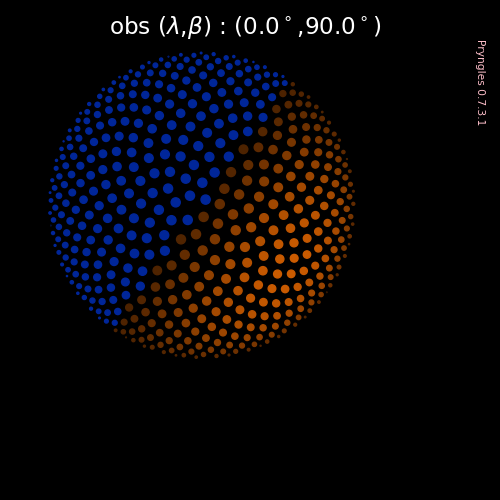

(-19.526779909695705, 14.022112258032063)

In [199]:
sys.integrate(hn.Ps[0]/3)
sys.update_perspective()
sys.sg.plot2d(include=["Planet","Moon"],axis=0)

In [200]:
#Animation
"""
for i,t in enumerate(tqdm(np.linspace(0,hn.Ps[0]/2,50))):
    sys.integrate(t)
    sys.update_perspective()
    if i==0:
        del sys.sg.fig2d
    sys.sg.plot2d(include=["Planet","Moon"],axis=0,newfig=False)
    if i==0:
        camera=Camera(sys.sg.fig2d)
    else:
        camera.snap()
anim=camera.animate(interval=1000,repeat=True,blit=False)
anim.save("tmp/orbit-animation.gif")
from IPython.display import Image
Image(open("tmp/orbit-animation.gif","rb").read())
""";

### Docstring

In [6]:
Scatterer_doc="""This is the basic class of a scatterer
"""

### Class structure

In [14]:
class Scatterer(PrynglesCommon):
    def __init__(self):
        pass
    
Scatterer.__doc__=Scatterer_doc

In [31]:
#Define system
nspangles=1000
sys=System()
S=sys.add(nspangles=nspangles)
P=sys.add("Planet",primary=S,nspangles=nspangles,radius=0.2,x=2)
sys.spangle_system()

In [37]:
sys.sg.plot2d(include=["Planet"])

TypeError: plot2d() got an unexpected keyword argument 'include'

In [32]:
sys.update_perspective(n_obs=sci.direction(90,0))

<IPython.core.display.Javascript object>


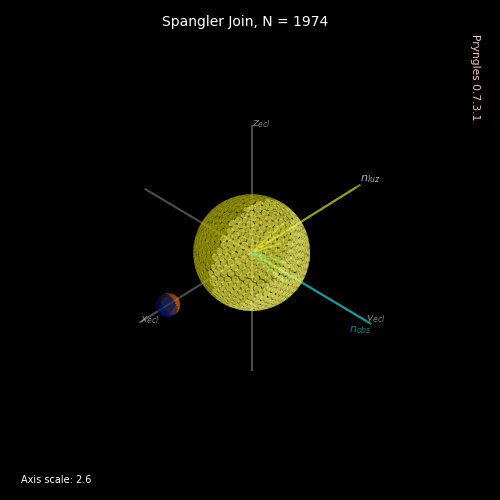

In [33]:
sys.sg.plot3d()

<IPython.core.display.Javascript object>


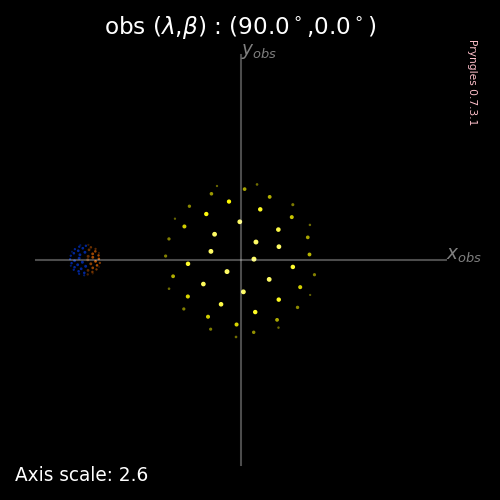

In [23]:
sys.sg.plot2d()

In [11]:
sys.sg.plot2d?

<IPython.core.display.Javascript object>


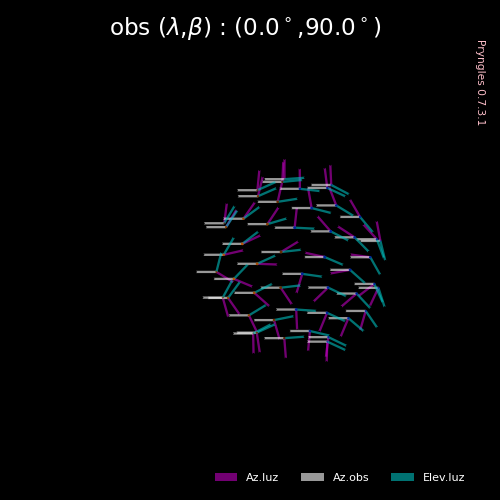

In [12]:
sys.sg.plot2d(show_azim=True)

In [17]:
#@test:template
if IN_JUPYTER:
    
    def test_fun(self):
        f=Foo()
        print(f)
        
    class Test(unittest.TestCase):pass
    Test.test_fun=test_fun
    unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end

.

{'a': 1, 'b': 2}



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Method development

In [19]:
#@method:Foo
def method2(self):
    return self.a+self.b
#@end

Foo.method2=method2

In [24]:
#@test:template
if IN_JUPYTER:
    
    def test_fun(self):
        f=Foo(-1,5)
        c=f.method2()
        print(c)
        
        """
        #Type of tests
        self.assertRaises(ValueError,lambda:Planet())
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        """
        
    class Test(unittest.TestCase):pass
    Test.test_fun=test_fun
    unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end

.

4



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## Further test 

This code is not included in final package files.

In [22]:
f=Foo()